# Downloading Dataset from Kaggle

When you will run this code, it will ask you to upload your api key file which will be in json format and you will have to upload that file to execute this code. You can use this link to get the API key to run this code: https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/ or you can use the file I uploaded in the appendix material named Kaggle API key file

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
100% 983M/987M [00:10<00:00, 110MB/s]
100% 987M/987M [00:10<00:00, 101MB/s]


In [ ]:
! mkdir dataset
! unzip -q /content/speech-emotion-recognition-en.zip -d /content/dataset

# Labeling Data

In [ ]:
import os
import csv

In [ ]:
female_crema = [
    1091, 1089, 1084, 1082, 1079, 1078, 1076, 1075, 1074, 1073, 1072, 1063, 1061, 1060, 1058, 1056, 1055, 1054, 1053, 1052, 1049, 1047,
    1046, 1043, 1037, 1030, 1029, 1028, 1025, 1024, 1021, 1020, 1018, 1013, 1012, 1010, 1009, 1008, 1007, 1006, 1004, 1003, 1002
]

def get_label_tess(path):
    parent_dir = os.path.basename(os.path.dirname(path))
    if "YAF_" in parent_dir:
        label = parent_dir.split("YAF_")[1]
    elif "OAF_" in parent_dir:
        label = parent_dir.split("OAF_")[1]
    else:
        label = None

    if label == "Pleasant_surprise" or label == "pleasant_surprised" or label == "pleasant_surprise":
        label = "surprise"
    return label, 'female'

def get_label_savee(path):
    file_name = os.path.basename(path).split('_')
    label_map = {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'sa': 'sad', 'su': 'surprise', 'n':'neutral'}
    label = file_name[1][0]
    if label == 's':
      label = file_name[1][0:2]
    return label_map.get(label, None), 'male'

def get_label_ravdess(path):
    file_name = os.path.basename(path).split('-')
    if int(file_name[-1][:2])%2 == 0:
      gender = 'female'
    else:
      gender = 'male'

    label = file_name[2]
    emotion_map = {'01': 'neutral', '02': 'neutral', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'}
    return emotion_map.get(label, None), gender

def get_label_crema(path):
    file_name = os.path.basename(path).split('_')
    label_map = {'SAD': 'sad', 'NEU': 'neutral', 'HAP': 'happy', 'FEA': 'fear', 'DIS': 'disgust', 'ANG': 'angry'}
    label = file_name[2]
    if int(file_name[0]) in female_crema:
      gender = "female"
    else:
      gender = 'male'
    return label_map.get(label, None), gender


In [ ]:
def process_directory(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if 'Tess' in directory:
                label,gender = get_label_tess(file_path)
            elif 'Savee' in directory:
                label,gender = get_label_savee(file_path)
            elif 'Ravdess' in directory:
                label,gender = get_label_ravdess(file_path)
            elif 'Crema' in directory:
                label,gender = get_label_crema(file_path)
            else:
                label = None

            if label:
                file_paths.append((file_path, label, gender))

    return file_paths

def write_csv(file_paths, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Path', 'Dataset', 'Label', 'Gender'])

        for path, label, gender in file_paths:
            if 'Tess' in path:
                  dataset = "Tess"
            elif 'Savee' in path:
                  dataset = "Savee"
            elif 'Ravdess' in path:
                  dataset = "Ravdess"
            elif 'Crema' in path:
                  dataset = "Crema"
            csv_writer.writerow([path, dataset, label.lower(), gender.lower()])

In [ ]:
root_dir = "/content/dataset/"  # Replace with the actual root directory containing the subdirectories (Tess, Savee, Ravdess, Crema)
output_csv = "label.csv"

all_file_paths = []
for subdir in os.listdir(root_dir):
    subdirectory = os.path.join(root_dir, subdir)
    if os.path.isdir(subdirectory):
        file_paths = process_directory(subdirectory)
        all_file_paths.extend(file_paths)

write_csv(all_file_paths, output_csv)

# Pre-Processing and Feature Extraction

In [ ]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
# Load the CSV file containing paths to audio files
csv_path = 'label.csv'
df = pd.read_csv(csv_path)
df['Label'] = df['Gender'] + '_' + df['Label']
df.drop('Gender', axis=1, inplace=True)
df.head()

,Path,Dataset,Label
0,/content/dataset/Crema/1056_IEO_SAD_MD.wav,Crema,female_sad
1,/content/dataset/Crema/1003_IWW_NEU_XX.wav,Crema,female_neutral
2,/content/dataset/Crema/1011_DFA_FEA_XX.wav,Crema,male_fear
3,/content/dataset/Crema/1077_IWL_HAP_XX.wav,Crema,male_happy
4,/content/dataset/Crema/1087_ITH_HAP_XX.wav,Crema,male_happy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     12162 non-null  object
 1   Dataset  12162 non-null  object
 2   Label    12162 non-null  object
dtypes: object(3)
memory usage: 285.2+ KB


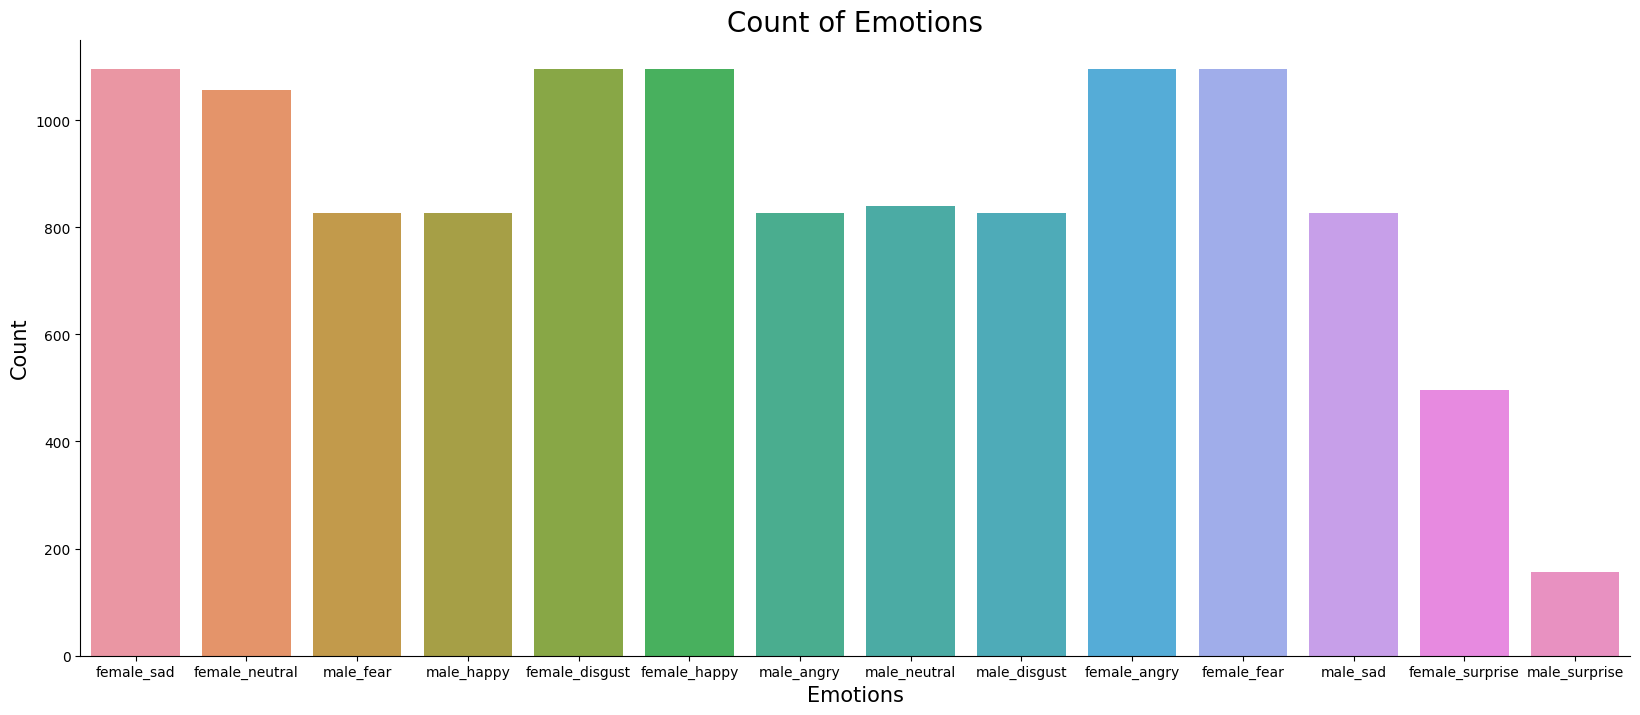

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(20,8))
sns.countplot(x=df.Label)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
audio_paths = df['Path'].tolist()
labels_string = df['Label'].values

## Adding data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)

## Extracting mfcc from all the newly formed data

In [ ]:
def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:
X, Y = [], []

for path, emotion in tqdm(zip(df.Path, df.Label), total=len(df)):  # Add tqdm to the loop
    features = get_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)

100%|██████████| 12162/12162 [59:24<00:00,  3.41it/s]


In [ ]:
#X=np.array(X)
#Y=np.array(Y)

In [ ]:
encoder = OneHotEncoder()
y = encoder.fit_transform(Y.reshape(-1,1)).toarray()
y.shape

(85134, 14)

In [ ]:
# Saving data for backup
np.save('x.npy', X)
np.save('y.npy', y)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58), (68107, 14), (17027, 58), (17027, 14))

# Model Formulation and training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dense, Concatenate
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

The pretrained models available in the keras support only images with three channels. But we only have single channel 1d array. So, we can build the same architecture and train model on our data, instead of using pretrained model

In [ ]:
def inception_block(x, filters):
    conv1x1 = Conv1D(filters, kernel_size=1, padding='same')(x)
    conv3x3 = Conv1D(filters, kernel_size=3, padding='same')(x)
    conv5x5 = Conv1D(filters, kernel_size=5, padding='same')(x)
    maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)

    concat = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool])
    return concat

input_layer = Input(shape=(58, 1))

x = Conv1D(32, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=64)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = inception_block(x, filters=128)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(14, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 58, 1)]      0           []                               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 29, 32)       256         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_47 (BatchN  (None, 29, 32)      128         ['conv1d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_35 (Activation)     (None, 29, 32)       0           ['batch_normalization_47[0]

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

# Define a callback to save the model checkpoints
checkpoint = ModelCheckpoint(
    filepath='inceptionNet.h5',  # Specify the filename
    monitor='val_accuracy',          # Metric to monitor for saving best weights
    save_best_only=True,             # Only save the best weights
    save_weights_only=False,         # Save the entire model (including architecture)
    verbose=1                         # Print messages when saving
)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping,checkpoint])

Epoch 1/50
1065/1065 [==============================] - ETA: 0s - loss: 1.5282 - accuracy: 0.4577
Epoch 1: val_accuracy improved from -inf to 0.52939, saving model to inceptionNet.h5
1065/1065 [==============================] - 16s 11ms/step - loss: 1.5282 - accuracy: 0.4577 - val_loss: 1.2495 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/50
1062/1065 [============================>.] - ETA: 0s - loss: 1.1599 - accuracy: 0.5696
Epoch 2: val_accuracy improved from 0.52939 to 0.57520, saving model to inceptionNet.h5
1065/1065 [==============================] - 13s 12ms/step - loss: 1.1594 - accuracy: 0.5698 - val_loss: 1.1652 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 3/50
1062/1065 [============================>.] - ETA: 0s - loss: 1.0123 - accuracy: 0.6217
Epoch 3: val_accuracy improved from 0.57520 to 0.58349, saving model to inceptionNet.h5
1065/1065 [==============================] - 11s 10ms/step - loss: 1.0122 - accuracy: 0.6217 - val_loss: 1.1563 - val_accuracy: 0.5835 - lr: 0.0010
E

# Evaluating results

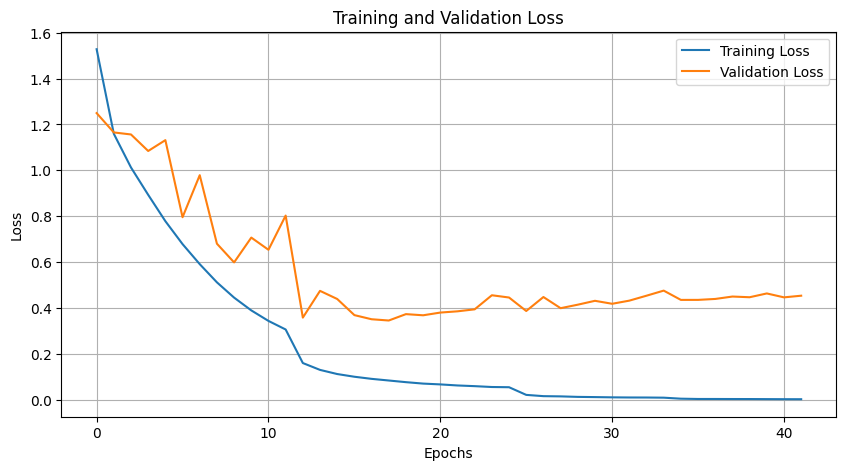

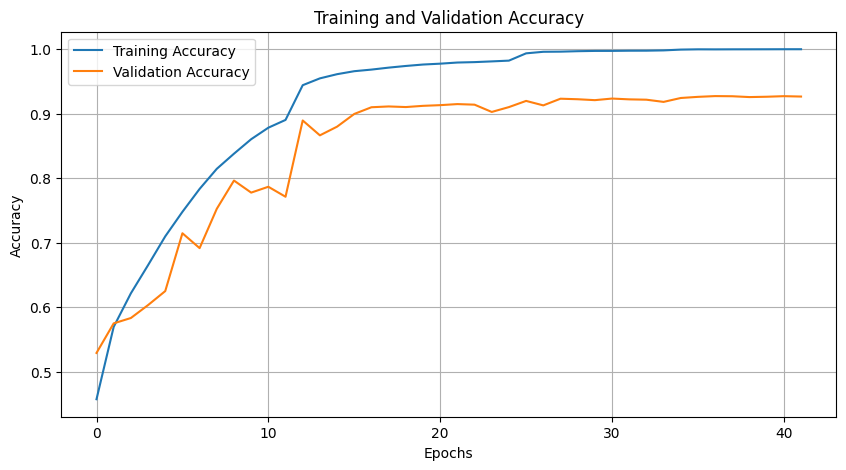

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()